In [1]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#import shap

from __future__ import absolute_import, division, print_function, unicode_literals
import argparse
import logging
import os
import sys
import io
import tensorflow as tf
import matplotlib.pylab as plt
from tensorflow.keras import layers
from tensorflow.keras import models
import numpy as np
from PIL import Image
import glob
from tensorflow.keras.preprocessing import image

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from tensorflow.keras import backend as K
import random
from tensorflow.keras.utils import plot_model
import re
tf.keras.backend.clear_session()
from callbacks import CallBacks
from model_factory import GetModel
from preprocess import Preprocess, format_example, format_example_tf, update_status
#from tf_explain.callbacks.grad_cam import GradCAMCallback
#from tf_explain.core.grad_cam import GradCAM
from pathlib import Path
import cv2
import numpy as np
from PIL import Image
import shap
from skimage import measure
import numpy as np
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from matplotlib import pyplot as plt
from descartes import PolygonPatch

/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1772: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
shapely.geos (DEBUG): Found GEOS DLL: <CDLL '/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/shapely/.libs/libgeos_c-a68605fd.so.1.13.1', handle 55685b67eb40 at 0x2b28bbf184a8>, using it.
shapely.geos (DEBUG): Trying `CDLL(libc.so.6)`
shapely.geos (DEBUG): Library path: 'libc.so.6'
shapely.geos (DEBUG): DLL: <CDLL 'libc.so.6', handle 2b2572b64000 at 0x2b25c2

In [2]:
filepath='/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/bw.nobg.1024.cnv_exprs_allgenes_log_bilinear_topvar_segment/VGG16_Nadam_1e-05-BinaryCrossentropy/my_model.h5'
input_folder="/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/grad_cam1/input_cnv_segment"
#output_folder="/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/grad_cam1/output_segment"

In [3]:
fobj=open("/infodev1/infoderm/Projects/Naresh/scripts/Kiosk/runs/SEX12.RUNLOG/all.txt")
dir_path="/infodev1/infoderm/Projects/Naresh/scripts/Kiosk/runs/SEX12.images/"
header=fobj.readline()
print(header)
tp=[]
tn=[]
fp=[]
fn=[]
trn_0=[]
trn_1=[]
for line in fobj:
    line=line.strip()
    arr=line.split(" ")
    imgfile=arr[1]
    true_lbl=int(arr[2])
    cate=arr[3]
    p1=float(arr[4])
    p2=float(arr[5])
    if cate=="test" and true_lbl==1 and p2>0.5:
        tp.append(dir_path+cate+'/'+str(true_lbl)+'/'+imgfile)
    if cate=="test" and true_lbl==1 and p2<0.5:
        fn.append(dir_path+cate+'/'+str(true_lbl)+'/'+imgfile)
    if cate=="test" and true_lbl==0 and p2<0.5:
        tn.append(dir_path+cate+'/'+str(true_lbl)+'/'+imgfile)
    if cate=="test" and true_lbl==0 and p2>0.5:
        fp.append(dir_path+cate+'/'+str(true_lbl)+'/'+imgfile)
    if cate=="train" and true_lbl==0:
        trn_0.append(dir_path+cate+'/'+str(true_lbl)+'/'+imgfile)
    if cate=="train" and true_lbl==1:
        trn_1.append(dir_path+cate+'/'+str(true_lbl)+'/'+imgfile)  
len(tp),len(tn),len(fp),len(fn),tp[:1],len(trn_0),len(trn_1), trn_0[0],trn_1[0]

FileNotFoundError: [Errno 2] No such file or directory: '/infodev1/infoderm/Projects/Naresh/scripts/Kiosk/runs/SEX12.RUNLOG/all.txt'

In [13]:
'''Loadmodel'''
#new_model = models.load_model(model_path)
checkpoint_dir=os.path.dirname(filepath)
model_name=os.path.basename(os.path.dirname(filepath))
model_type = model_name.split("_")[0]
optimizer = model_name.split("_")[1]
loss_function = model_name.split("-")[-1]
lr = float(model_name.split("_")[-1].replace(loss_function,"")[:-1])
#print(model_type,optimizer,loss_function,lr)
#sys.exit(0)
'''Loadmodel'''
#new_model = models.load_model(filepath)
m = GetModel(model_name=model_type, img_size=256, classes=2, num_layers=None, reg_drop_out_per=None, l2_reg=None)
new_model = m.compile_model(optimizer, lr, loss_function)
latest = tf.train.latest_checkpoint(checkpoint_dir)
#print(latest)
new_model.load_weights(latest)

Model loaded was VGG16


In [14]:
IMAGE_SHAPE = (256, 256)
#files=os.listdir(input_folder)
#layer_name="conv5_block3_3_conv"
#layer_name="block4_conv3" 
import glob
files=glob.glob(input_folder+'/*.png')
len(files),files[:5]

(4,
 ['/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/grad_cam1/input_cnv_segment/TCGA-21-5786-01.png',
  '/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/grad_cam1/input_cnv_segment/TCGA-05-4417-01.png',
  '/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/grad_cam1/input_cnv_segment/TCGA-05-4415-01.png',
  '/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_TCGA/grad_cam1/input_cnv_segment/TCGA-21-A5DI-01.png'])

In [8]:
# !export KERAS_HOME="/research/bsi/projects/staff_analysis/m081429/keras_model_download_dir"


In [9]:
!pwd

/research/bsi/projects/pharmacogenetics/s112047.beauty/analyses/manuscripts/Naresh_ML_DP_2_2_2021/code/General-ImageClassifier_hsv_bilinear


In [10]:
#model = ResNet50(weights='imagenet')
#X, y = shap.datasets.imagenet50()
#X.shape, y.shape, X.size, X.dtype, y.dtype
# getting ImageNet 1000 class names
#url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
#with open(shap.datasets.cache(url)) as file:
#    class_names = [v[1] for v in json.load(file).values()]
#print("Number of ImageNet classes:", len(class_names))
#print("Class names:", class_names)
#tn[0:5]+tp[0:5]

In [8]:
#files=tn[0:5]+tp[0:5]#fp[0:3]+fn[0:3]+tn[0:3]
#file_base = trn_0[:500]+trn_1[:500]
print(len(files))
#layer_name="conv5_block3_3_conv"
files_img=[]
#file_base_img=[]
#layer_name="block4_conv3"

def f(x):
    tmp = x.copy()
    b = K.constant(tmp)
    b = tf.cast(b, tf.float32)/255
    #b = tf.io.decode_jpeg(b, channels=3)
    b = tf.image.resize(b, IMAGE_SHAPE)
    #b = tf.image.rgb_to_hsv(b)
    #b = tf.reshape(b, (IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3))
    #tmp=K.eval(b)
    #tmp = np.expand_dims(tmp, axis=0)
    return new_model(b)
    #return b

for imgpath in files:
    orig=imgpath #os.path.join(input_folder,imgpath)
    imgpath=imgpath.replace('.jpg','_out.jpg')
    tmp1=np.asarray(Image.open(orig).convert("RGB").resize(IMAGE_SHAPE))
    files_img.append(tmp1)
    
#for imgpath in file_base:
#    orig=imgpath #os.path.join(input_folder,imgpath)
#    imgpath=imgpath.replace('.jpg','_out.jpg')
#    #print(orig)
#    tmp1=np.asarray(Image.open(orig).convert("RGB").resize(IMAGE_SHAPE))
#    file_base_img.append(tmp1)

PIL.PngImagePlugin (DEBUG): STREAM b'IHDR' 16 13
PIL.PngImagePlugin (DEBUG): STREAM b'PLTE' 41 768
PIL.PngImagePlugin (DEBUG): STREAM b'IDAT' 821 8192
PIL.PngImagePlugin (DEBUG): STREAM b'IHDR' 16 13
PIL.PngImagePlugin (DEBUG): STREAM b'PLTE' 41 768
PIL.PngImagePlugin (DEBUG): STREAM b'IDAT' 821 8192


4


PIL.PngImagePlugin (DEBUG): STREAM b'IHDR' 16 13
PIL.PngImagePlugin (DEBUG): STREAM b'PLTE' 41 768
PIL.PngImagePlugin (DEBUG): STREAM b'IDAT' 821 8192
PIL.PngImagePlugin (DEBUG): STREAM b'IHDR' 16 13
PIL.PngImagePlugin (DEBUG): STREAM b'PLTE' 41 768
PIL.PngImagePlugin (DEBUG): STREAM b'IDAT' 821 8192


In [15]:
X = np.asarray(files_img)
#X_base = np.asarray(file_base_img)
X.shape#,X_base.shape

(4, 256, 256, 3)

In [10]:
#f(X)

In [11]:
class_names=['0','1']
len(class_names),X[0:4,:,:,:].shape

(2, (4, 256, 256, 3))

In [5]:
#shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough 
#shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough
# DeepExplainer to explain predictions of the model
#explainer = shap.KernelExplainer(new_model, X_base[0:1000])
# compute shap values
#shap_values = explainer.shap_values(X[0,:,:,:],nsamples=500)

numba.core.interpreter (DEBUG): label 0:
    averaged_outs = arg(0, name=averaged_outs) ['averaged_outs']
    last_outs = arg(1, name=last_outs)       ['last_outs']
    outputs = arg(2, name=outputs)           ['outputs']
    batch_positions = arg(3, name=batch_positions) ['batch_positions']
    varying_rows = arg(4, name=varying_rows) ['varying_rows']
    num_varying_rows = arg(5, name=num_varying_rows) ['num_varying_rows']
    link = arg(6, name=link)                 ['link']
    linearizing_weights = arg(7, name=linearizing_weights) ['linearizing_weights']
    $0.2 = getattr(value=last_outs, attr=shape) ['$0.2', 'last_outs']
    $const0.3 = const(int, 0)                ['$const0.3']
    sample_count = getitem(value=$0.2, index=$const0.3, fn=<built-in function getitem>) ['$0.2', '$const0.3', 'sample_count']
    jump 12                                  []
label 12:
    jump 16                                  []
label 16:
    $16.1 = global(range: <class 'range'>)   ['$16.1']
    $con

numba.core.ssa (DEBUG): ==== SSA block analysis pass on 0
numba.core.ssa (DEBUG): Running <numba.core.ssa._GatherDefsHandler object at 0x2b28cff8c2b0>
numba.core.ssa (DEBUG): on stmt: averaged_outs = arg(0, name=averaged_outs)
numba.core.ssa (DEBUG): on stmt: last_outs = arg(1, name=last_outs)
numba.core.ssa (DEBUG): on stmt: outputs = arg(2, name=outputs)
numba.core.ssa (DEBUG): on stmt: batch_positions = arg(3, name=batch_positions)
numba.core.ssa (DEBUG): on stmt: varying_rows = arg(4, name=varying_rows)
numba.core.ssa (DEBUG): on stmt: num_varying_rows = arg(5, name=num_varying_rows)
numba.core.ssa (DEBUG): on stmt: link = arg(6, name=link)
numba.core.ssa (DEBUG): on stmt: linearizing_weights = arg(7, name=linearizing_weights)
numba.core.ssa (DEBUG): on stmt: $0.2 = getattr(value=last_outs, attr=shape)
numba.core.ssa (DEBUG): on stmt: $const0.3 = const(int, 0)
numba.core.ssa (DEBUG): on stmt: sample_count = static_getitem(value=$0.2, index=0, index_var=$const0.3, fn=<built-in funct

numba.core.ssa (DEBUG): on stmt: $236.2 = iternext(value=$phi236.1)
numba.core.ssa (DEBUG): on stmt: $236.3 = pair_first(value=$236.2)
numba.core.ssa (DEBUG): on stmt: $236.4 = pair_second(value=$236.2)
numba.core.ssa (DEBUG): on stmt: $phi238.1 = $236.3
numba.core.ssa (DEBUG): on stmt: $phi276.1 = $236.3
numba.core.ssa (DEBUG): on stmt: $phi276.2 = $phi236.1
numba.core.ssa (DEBUG): on stmt: branch $236.4, 238, 276
numba.core.ssa (DEBUG): ==== SSA block analysis pass on 238
numba.core.ssa (DEBUG): Running <numba.core.ssa._GatherDefsHandler object at 0x2b28cff8c2b0>
numba.core.ssa (DEBUG): on stmt: j = $phi238.1
numba.core.ssa (DEBUG): on stmt: $238.3 = global(np: <module 'numpy' from '/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/numpy/__init__.py'>)
numba.core.ssa (DEBUG): on stmt: $238.4 = getattr(value=$238.3, attr=mean)
numba.core.ssa (DEBUG): on stmt: $const238.6 = const(NoneType, None)
numba.core.

numba.core.ssa (DEBUG): SSA violators set()
numba.core.interpreter (DEBUG): label 0:
    x = arg(0, name=x)                       ['x']
    $0.2 = cast(value=x)                     ['$0.2', 'x']
    return $0.2                              ['$0.2']

numba.core.ssa (DEBUG): ==== SSA block analysis pass on 0
numba.core.ssa (DEBUG): Running <numba.core.ssa._GatherDefsHandler object at 0x2b2913f7de80>
numba.core.ssa (DEBUG): on stmt: x = arg(0, name=x)
numba.core.ssa (DEBUG): on stmt: $0.2 = cast(value=x)
numba.core.ssa (DEBUG): on stmt: return $0.2
numba.core.ssa (DEBUG): defs defaultdict(<class 'list'>,
            {'$0.2': [<numba.core.ir.Assign object at 0x2b2913f59dd8>],
             'x': [<numba.core.ir.Assign object at 0x2b2913f7d2e8>]})
numba.core.ssa (DEBUG): SSA violators set()
numba.core.interpreter (DEBUG): label 0:
    arr = arg(0, name=arr)                   ['arr']
    c = freevar(zero: 0.0)                   ['c']
    jump 6                                   []
label 6:
   

numba.core.ssa (DEBUG): Running <numba.core.ssa._FreshVarHandler object at 0x2b2b07f98470>
numba.core.ssa (DEBUG): on stmt: $8.1 = global(np: <module 'numpy' from '/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/numpy/__init__.py'>)
numba.core.ssa (DEBUG): on stmt: $8.2 = getattr(value=$8.1, attr=nditer)
numba.core.ssa (DEBUG): on stmt: $8.4 = call $8.2(arr, func=$8.2, args=[Var(arr, arraymath.py:411)], kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: $8.5 = getiter(value=$8.4)
numba.core.ssa (DEBUG): on stmt: $phi18.1 = $8.5
numba.core.ssa (DEBUG): on stmt: jump 18
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 18
numba.core.ssa (DEBUG): Running <numba.core.ssa._FreshVarHandler object at 0x2b2b07f98470>
numba.core.ssa (DEBUG): on stmt: $18.2 = iternext(value=$phi18.1)
numba.core.ssa (DEBUG): on stmt: $18.3 = pair_first(value=$18.2)
numba.core.ssa (DEBUG): on stmt: $18.4 = pair_second(value=$

numba.core.ssa (DEBUG): ==== SSA block analysis pass on 0
numba.core.ssa (DEBUG): Running <numba.core.ssa._GatherDefsHandler object at 0x2b2b8bf82e80>
numba.core.ssa (DEBUG): on stmt: shape = arg(0, name=shape)
numba.core.ssa (DEBUG): on stmt: main_shape = arg(1, name=main_shape)
numba.core.ssa (DEBUG): on stmt: $0.1 = global(len: <built-in function len>)
numba.core.ssa (DEBUG): on stmt: n = const(int, 1)
numba.core.ssa (DEBUG): on stmt: jump 10
numba.core.ssa (DEBUG): ==== SSA block analysis pass on 10
numba.core.ssa (DEBUG): Running <numba.core.ssa._GatherDefsHandler object at 0x2b2b8bf82e80>
numba.core.ssa (DEBUG): on stmt: jump 12
numba.core.ssa (DEBUG): ==== SSA block analysis pass on 12
numba.core.ssa (DEBUG): Running <numba.core.ssa._GatherDefsHandler object at 0x2b2b8bf82e80>
numba.core.ssa (DEBUG): on stmt: $12.1 = global(range: <class 'range'>)
numba.core.ssa (DEBUG): on stmt: $12.3 = call $12.1(n, func=$12.1, args=[Var(n, arrayobj.py:2716)], kws=(), vararg=None)
numba.core.s

numba.core.interpreter (DEBUG): label 0:
    i = arg(0, name=i)                       ['i']
    value = arg(1, name=value)               ['value']
    M = arg(2, name=M)                       ['M']
    values = arg(3, name=values)             ['values']
    clustering = arg(4, name=clustering)     ['clustering']
    $0.3 = i < M                             ['$0.3', 'M', 'i']
    bool8 = global(bool: <class 'bool'>)     ['bool8']
    $8pred = call bool8($0.3, func=bool8, args=(Var($0.3, _partition.py:677),), kws=(), vararg=None) ['$0.3', '$8pred', 'bool8']
    branch $8pred, 10, 30                    ['$8pred']
label 10:
    $10.5 = getitem(value=values, index=i, fn=<built-in function getitem>) ['$10.5', 'i', 'values']
    $10.7 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=$10.5, rhs=value, static_lhs=Undefined, static_rhs=Undefined) ['$10.5', '$10.7', 'value']
    values[i] = $10.7                        ['$10.7', 'i', 'values']
    $const10.8 

numba.core.ssa (DEBUG): on stmt: M = arg(2, name=M)
numba.core.ssa (DEBUG): on stmt: values = arg(3, name=values)
numba.core.ssa (DEBUG): on stmt: clustering = arg(4, name=clustering)
numba.core.ssa (DEBUG): on stmt: $0.3 = i < M
numba.core.ssa (DEBUG): on stmt: bool8 = global(bool: <class 'bool'>)
numba.core.ssa (DEBUG): on stmt: $8pred = call bool8($0.3, func=bool8, args=(Var($0.3, _partition.py:677),), kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: branch $8pred, 10, 30
numba.core.ssa (DEBUG): ==== SSA block analysis pass on 10
numba.core.ssa (DEBUG): Running <numba.core.ssa._GatherDefsHandler object at 0x2b2d635b1ba8>
numba.core.ssa (DEBUG): on stmt: $10.5 = getitem(value=values, index=i, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: $10.7 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=$10.5, rhs=value, static_lhs=Undefined, static_rhs=Undefined)
numba.core.ssa (DEBUG): on stmt: values[i] = $10.7
numba.core.ssa (DEBU

numba.core.ssa (DEBUG): on stmt: $170.25 = getitem(value=values, index=i, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: $170.27 = $170.25 * rsize
numba.core.ssa (DEBUG): on stmt: $170.29 = $170.27 / group_size
numba.core.ssa (DEBUG): on stmt: $170.33 = call $170.21(ri, $170.29, M, values, clustering, func=$170.21, args=[Var(ri, _partition.py:681), Var($170.29, _partition.py:688), Var(M, _partition.py:677), Var(values, _partition.py:677), Var(clustering, _partition.py:677)], kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: $const170.34 = const(NoneType, None)
numba.core.ssa (DEBUG): on stmt: $170.35 = cast(value=$const170.34)
numba.core.ssa (DEBUG): on stmt: return $170.35
numba.core.ssa (DEBUG): defs defaultdict(<class 'list'>,
            {'$0.3': [<numba.core.ir.Assign object at 0x2b2913f4d470>],
             '$10.5': [<numba.core.ir.Assign object at 0x2b28cffbf7f0>],
             '$10.7': [<numba.core.ir.Assign object at 0x2b28cffbfda0>],
             '$10.9'

numba.core.ssa (DEBUG): on stmt: $30.7 = build_tuple(items=[Var($30.5, _partition.py:680), Var($const30.6, _partition.py:680)])
numba.core.ssa (DEBUG): on stmt: $30.8 = getitem(value=clustering, index=$30.7, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: li = call $30.1($30.8, func=$30.1, args=[Var($30.8, _partition.py:680)], kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: $30.10 = global(int: <class 'int'>)
numba.core.ssa (DEBUG): on stmt: $30.14 = i - M
numba.core.ssa (DEBUG): on stmt: $const30.15 = const(int, 1)
numba.core.ssa (DEBUG): on stmt: $30.16 = build_tuple(items=[Var($30.14, _partition.py:681), Var($const30.15, _partition.py:681)])
numba.core.ssa (DEBUG): on stmt: $30.17 = getitem(value=clustering, index=$30.16, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: ri = call $30.10($30.17, func=$30.10, args=[Var($30.17, _partition.py:681)], kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: $30.19 = global(int: <class 'int'>)
numba.core

numba.core.ssa (DEBUG): on stmt: $0.3 = i < M
numba.core.ssa (DEBUG): on stmt: bool8 = global(bool: <class 'bool'>)
numba.core.ssa (DEBUG): on stmt: $8pred = call bool8($0.3, func=bool8, args=(Var($0.3, _partition.py:677),), kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: branch $8pred, 10, 30
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 10
numba.core.ssa (DEBUG): Running <numba.core.ssa._FixSSAVars object at 0x2b2d635879b0>
numba.core.ssa (DEBUG): on stmt: $10.5 = getitem(value=values, index=i, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: $10.7 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=$10.5, rhs=value, static_lhs=Undefined, static_rhs=Undefined)
numba.core.ssa (DEBUG): on stmt: values[i] = $10.7
numba.core.ssa (DEBUG): on stmt: $const10.8 = const(NoneType, None)
numba.core.ssa (DEBUG): on stmt: $10.9 = cast(value=$const10.8)
numba.core.ssa (DEBUG): on stmt: return $10.9
numba.core.ssa (DEBUG): ==== SSA b

numba.core.ssa (DEBUG): on stmt: $170.21 = global(lower_credit: CPUDispatcher(<function lower_credit at 0x2b28b5ea8e18>))
numba.core.ssa (DEBUG): on stmt: $170.25 = getitem(value=values, index=i, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: $170.27 = $170.25 * rsize
numba.core.ssa (DEBUG): on stmt: $170.29 = $170.27 / group_size
numba.core.ssa (DEBUG): on stmt: $170.33 = call $170.21(ri, $170.29, M, values, clustering, func=$170.21, args=[Var(ri, _partition.py:681), Var($170.29, _partition.py:688), Var(M, _partition.py:677), Var(values, _partition.py:677), Var(clustering, _partition.py:677)], kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: $const170.34 = const(NoneType, None)
numba.core.ssa (DEBUG): on stmt: $170.35 = cast(value=$const170.34)
numba.core.ssa (DEBUG): on stmt: return $170.35
numba.core.ssa (DEBUG): Fix SSA violator on var $phi152.1
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 0
numba.core.ssa (DEBUG): Running <numba.core.ssa._FreshVarH

numba.core.ssa (DEBUG): on stmt: $166.1 = global(AssertionError: <class 'AssertionError'>)
numba.core.ssa (DEBUG): on stmt: <static> raise <class 'AssertionError'>
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 170
numba.core.ssa (DEBUG): Running <numba.core.ssa._FreshVarHandler object at 0x2b2d635b17b8>
numba.core.ssa (DEBUG): on stmt: $170.5 = getitem(value=values, index=i, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: $170.7 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=$170.5, rhs=value, static_lhs=Undefined, static_rhs=Undefined)
numba.core.ssa (DEBUG): on stmt: values[i] = $170.7
numba.core.ssa (DEBUG): on stmt: $170.8 = global(lower_credit: CPUDispatcher(<function lower_credit at 0x2b28b5ea8e18>))
numba.core.ssa (DEBUG): on stmt: $170.12 = getitem(value=values, index=i, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: $170.14 = $170.12 * lsize
numba.core.ssa (DEBUG): on stmt: $170.16 = $170.14 / 

numba.core.ssa (DEBUG): on stmt: $130.9 = call $130.1($130.8, func=$130.1, args=[Var($130.8, _partition.py:684)], kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: $phi152.1 = $130.9
numba.core.ssa (DEBUG): on stmt: jump 152
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 150
numba.core.ssa (DEBUG): Running <numba.core.ssa._FixSSAVars object at 0x2b2d63596eb8>
numba.core.ssa (DEBUG): on stmt: $const150.1 = const(int, 1)
numba.core.ssa (DEBUG): on stmt: $phi152.1.1 = $const150.1
numba.core.ssa (DEBUG): on stmt: jump 152
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 152
numba.core.ssa (DEBUG): Running <numba.core.ssa._FixSSAVars object at 0x2b2d63596eb8>
numba.core.ssa (DEBUG): on stmt: rsize = $phi152.1
numba.core.ssa (DEBUG): find_def var='$phi152.1' stmt=rsize = $phi152.1
numba.core.ssa (DEBUG): find_def_from_top label 152
numba.core.ssa (DEBUG): insert phi node $phi152.1.2 = phi(incoming_values=[], incoming_blocks=[]) at 152
numba.core.ssa (DEBUG): find_def_from_b

numba.core.ssa (DEBUG): ==== SSA block analysis pass on 0
numba.core.ssa (DEBUG): Running <numba.core.ssa._GatherDefsHandler object at 0x2b2d4bf91780>
numba.core.ssa (DEBUG): on stmt: i = arg(0, name=i)
numba.core.ssa (DEBUG): on stmt: value = arg(1, name=value)
numba.core.ssa (DEBUG): on stmt: M = arg(2, name=M)
numba.core.ssa (DEBUG): on stmt: values = arg(3, name=values)
numba.core.ssa (DEBUG): on stmt: clustering = arg(4, name=clustering)
numba.core.ssa (DEBUG): on stmt: $0.3 = i < M
numba.core.ssa (DEBUG): on stmt: bool8 = global(bool: <class 'bool'>)
numba.core.ssa (DEBUG): on stmt: $8pred = call bool8($0.3, func=bool8, args=(Var($0.3, _partition.py:677),), kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: branch $8pred, 10, 30
numba.core.ssa (DEBUG): ==== SSA block analysis pass on 10
numba.core.ssa (DEBUG): Running <numba.core.ssa._GatherDefsHandler object at 0x2b2d4bf91780>
numba.core.ssa (DEBUG): on stmt: $10.5 = getitem(value=values, index=i, fn=<built-in function getite

numba.core.ssa (DEBUG): on stmt: $10.9 = cast(value=$const10.8)
numba.core.ssa (DEBUG): on stmt: return $10.9
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 30
numba.core.ssa (DEBUG): Running <numba.core.ssa._FreshVarHandler object at 0x2b2d635b9ba8>
numba.core.ssa (DEBUG): on stmt: $30.1 = global(int: <class 'int'>)
numba.core.ssa (DEBUG): on stmt: $30.5 = i - M
numba.core.ssa (DEBUG): on stmt: $const30.6 = const(int, 0)
numba.core.ssa (DEBUG): on stmt: $30.7 = build_tuple(items=[Var($30.5, _partition.py:680), Var($const30.6, _partition.py:680)])
numba.core.ssa (DEBUG): on stmt: $30.8 = getitem(value=clustering, index=$30.7, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: li = call $30.1($30.8, func=$30.1, args=[Var($30.8, _partition.py:680)], kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: $30.10 = global(int: <class 'int'>)
numba.core.ssa (DEBUG): on stmt: $30.14 = i - M
numba.core.ssa (DEBUG): on stmt: $const30.15 = const(int, 1)
numba.core.ssa (DEBUG

numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 0
numba.core.ssa (DEBUG): Running <numba.core.ssa._FixSSAVars object at 0x2b2d4bf919e8>
numba.core.ssa (DEBUG): on stmt: i = arg(0, name=i)
numba.core.ssa (DEBUG): on stmt: value = arg(1, name=value)
numba.core.ssa (DEBUG): on stmt: M = arg(2, name=M)
numba.core.ssa (DEBUG): on stmt: values = arg(3, name=values)
numba.core.ssa (DEBUG): on stmt: clustering = arg(4, name=clustering)
numba.core.ssa (DEBUG): on stmt: $0.3 = i < M
numba.core.ssa (DEBUG): on stmt: bool8 = global(bool: <class 'bool'>)
numba.core.ssa (DEBUG): on stmt: $8pred = call bool8($0.3, func=bool8, args=(Var($0.3, _partition.py:677),), kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: branch $8pred, 10, 30
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 10
numba.core.ssa (DEBUG): Running <numba.core.ssa._FixSSAVars object at 0x2b2d4bf919e8>
numba.core.ssa (DEBUG): on stmt: $10.5 = getitem(value=values, index=i, fn=<built-in function getitem>)
numba.core.s

numba.core.ssa (DEBUG): on stmt: $170.12 = getitem(value=values, index=i, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: $170.14 = $170.12 * lsize
numba.core.ssa (DEBUG): on stmt: $170.16 = $170.14 / group_size
numba.core.ssa (DEBUG): on stmt: $170.20 = call $170.8(li, $170.16, M, values, clustering, func=$170.8, args=[Var(li, _partition.py:680), Var($170.16, _partition.py:687), Var(M, _partition.py:677), Var(values, _partition.py:677), Var(clustering, _partition.py:677)], kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: $170.21 = global(lower_credit: CPUDispatcher(<function lower_credit at 0x2b28b5ea8e18>))
numba.core.ssa (DEBUG): on stmt: $170.25 = getitem(value=values, index=i, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: $170.27 = $170.25 * rsize
numba.core.ssa (DEBUG): on stmt: $170.29 = $170.27 / group_size
numba.core.ssa (DEBUG): on stmt: $170.33 = call $170.21(ri, $170.29, M, values, clustering, func=$170.21, args=[Var(ri, _partition.p

numba.core.ssa (DEBUG): on stmt: $152.4 = lsize + rsize
numba.core.ssa (DEBUG): on stmt: $152.6 = $152.4 == group_size
numba.core.ssa (DEBUG): on stmt: bool164 = global(bool: <class 'bool'>)
numba.core.ssa (DEBUG): on stmt: $164pred = call bool164($152.6, func=bool164, args=(Var($152.6, _partition.py:685),), kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: branch $164pred, 170, 166
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 166
numba.core.ssa (DEBUG): Running <numba.core.ssa._FreshVarHandler object at 0x2b2d635b9ba8>
numba.core.ssa (DEBUG): on stmt: $166.1 = global(AssertionError: <class 'AssertionError'>)
numba.core.ssa (DEBUG): on stmt: <static> raise <class 'AssertionError'>
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 170
numba.core.ssa (DEBUG): Running <numba.core.ssa._FreshVarHandler object at 0x2b2d635b9ba8>
numba.core.ssa (DEBUG): on stmt: $170.5 = getitem(value=values, index=i, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: $170.7 =

numba.core.ssa (DEBUG): Running <numba.core.ssa._FixSSAVars object at 0x2b2d4bf91978>
numba.core.ssa (DEBUG): on stmt: $130.1 = global(int: <class 'int'>)
numba.core.ssa (DEBUG): on stmt: $130.5 = ri - M
numba.core.ssa (DEBUG): on stmt: $const130.6 = const(int, 3)
numba.core.ssa (DEBUG): on stmt: $130.7 = build_tuple(items=[Var($130.5, _partition.py:684), Var($const130.6, _partition.py:684)])
numba.core.ssa (DEBUG): on stmt: $130.8 = getitem(value=clustering, index=$130.7, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: $130.9 = call $130.1($130.8, func=$130.1, args=[Var($130.8, _partition.py:684)], kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: $phi152.1 = $130.9
numba.core.ssa (DEBUG): on stmt: jump 152
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 150
numba.core.ssa (DEBUG): Running <numba.core.ssa._FixSSAVars object at 0x2b2d4bf91978>
numba.core.ssa (DEBUG): on stmt: $const150.1 = const(int, 1)
numba.core.ssa (DEBUG): on stmt: $phi152.1.1 = $const15

numba.core.typeinfer (DEBUG): captured error
Traceback (most recent call last):
  File "/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/numba/core/typeinfer.py", line 154, in propagate
    constraint(typeinfer)
  File "/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/numba/core/typeinfer.py", line 566, in __call__
    self.resolve(typeinfer, typevars, fnty)
  File "/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/numba/core/typeinfer.py", line 615, in resolve
    raise TypingError(msg)
numba.core.errors.TypingError: Invalid use of recursive(type(CPUDispatcher(<function lower_credit at 0x2b28b5ea8e18>))) with parameters (int64, array(float64, 1d, C), int64, array(float64, 2d, C), array(float64, 2d, C))
No type info available for recursive(type(CPU

numba.core.typeinfer (DEBUG): captured error
Traceback (most recent call last):
  File "/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/numba/core/typeinfer.py", line 154, in propagate
    constraint(typeinfer)
  File "/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/numba/core/typeinfer.py", line 566, in __call__
    self.resolve(typeinfer, typevars, fnty)
  File "/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/numba/core/typeinfer.py", line 615, in resolve
    raise TypingError(msg)
numba.core.errors.TypingError: Invalid use of recursive(type(CPUDispatcher(<function lower_credit at 0x2b28b5ea8e18>))) with parameters (int64, array(float64, 1d, C), int64, array(float64, 2d, C), array(float64, 2d, C))
No type info available for recursive(type(CPU

numba.core.typeinfer (DEBUG): captured error
Traceback (most recent call last):
  File "/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/numba/core/typeinfer.py", line 154, in propagate
    constraint(typeinfer)
  File "/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/numba/core/typeinfer.py", line 566, in __call__
    self.resolve(typeinfer, typevars, fnty)
  File "/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Naresh/conda_env/tf21/lib/python3.6/site-packages/numba/core/typeinfer.py", line 615, in resolve
    raise TypingError(msg)
numba.core.errors.TypingError: Invalid use of recursive(type(CPUDispatcher(<function lower_credit at 0x2b28b5ea8e18>))) with parameters (int64, array(float64, 1d, C), int64, array(float64, 2d, C), array(float64, 2d, C))
No type info available for recursive(type(CPU

numba.core.ssa (DEBUG): on stmt: $8pred = call bool8($0.3, func=bool8, args=(Var($0.3, npyimpl.py:205),), kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: branch $8pred, 10, 14
numba.core.ssa (DEBUG): ==== SSA block analysis pass on 10
numba.core.ssa (DEBUG): Running <numba.core.ssa._GatherDefsHandler object at 0x2b2d6cf9df98>
numba.core.ssa (DEBUG): on stmt: $const10.1 = const(int, 0)
numba.core.ssa (DEBUG): on stmt: $10.2 = cast(value=$const10.1)
numba.core.ssa (DEBUG): on stmt: return $10.2
numba.core.ssa (DEBUG): ==== SSA block analysis pass on 14
numba.core.ssa (DEBUG): Running <numba.core.ssa._GatherDefsHandler object at 0x2b2d6cf9df98>
numba.core.ssa (DEBUG): on stmt: src_index = const(int, 0)
numba.core.ssa (DEBUG): on stmt: dest_index = dest_ndim - src_ndim
numba.core.ssa (DEBUG): on stmt: jump 26
numba.core.ssa (DEBUG): ==== SSA block analysis pass on 26
numba.core.ssa (DEBUG): Running <numba.core.ssa._GatherDefsHandler object at 0x2b2d6cf9df98>
numba.core.ssa (DEBUG): o

numba.core.ssa (DEBUG): SSA violators {'dest_index', 'src_index'}
numba.core.ssa (DEBUG): Fix SSA violator on var dest_index
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 0
numba.core.ssa (DEBUG): Running <numba.core.ssa._FreshVarHandler object at 0x2b2d6cf8f278>
numba.core.ssa (DEBUG): on stmt: src_ndim = arg(0, name=src_ndim)
numba.core.ssa (DEBUG): on stmt: src_shape = arg(1, name=src_shape)
numba.core.ssa (DEBUG): on stmt: dest_ndim = arg(2, name=dest_ndim)
numba.core.ssa (DEBUG): on stmt: dest_shape = arg(3, name=dest_shape)
numba.core.ssa (DEBUG): on stmt: $0.3 = src_ndim > dest_ndim
numba.core.ssa (DEBUG): on stmt: bool8 = global(bool: <class 'bool'>)
numba.core.ssa (DEBUG): on stmt: $8pred = call bool8($0.3, func=bool8, args=(Var($0.3, npyimpl.py:205),), kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: branch $8pred, 10, 14
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 10
numba.core.ssa (DEBUG): Running <numba.core.ssa._FreshVarHandler object at 0x2b2d6cf

numba.core.ssa (DEBUG): on stmt: jump 26
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 26
numba.core.ssa (DEBUG): Running <numba.core.ssa._FixSSAVars object at 0x2b2d6cf75630>
numba.core.ssa (DEBUG): on stmt: jump 28
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 28
numba.core.ssa (DEBUG): Running <numba.core.ssa._FixSSAVars object at 0x2b2d6cf75630>
numba.core.ssa (DEBUG): on stmt: $28.3 = src_index < src_ndim
numba.core.ssa (DEBUG): on stmt: bool34 = global(bool: <class 'bool'>)
numba.core.ssa (DEBUG): on stmt: $34pred = call bool34($28.3, func=bool34, args=(Var($28.3, npyimpl.py:212),), kws=(), vararg=None)
numba.core.ssa (DEBUG): on stmt: branch $34pred, 36, 122
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 36
numba.core.ssa (DEBUG): Running <numba.core.ssa._FixSSAVars object at 0x2b2d6cf75630>
numba.core.ssa (DEBUG): on stmt: src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
numba.core.ssa (DEBUG): on stmt: dest_dim_

numba.core.ssa (DEBUG): find_def_from_bottom label 122
numba.core.ssa (DEBUG): find_def_from_top label 122
numba.core.ssa (DEBUG): idom 28 from label 122
numba.core.ssa (DEBUG): find_def_from_bottom label 28
numba.core.ssa (DEBUG): replaced with: $124.2 = cast(value=dest_index.2)
numba.core.ssa (DEBUG): on stmt: return $124.2
numba.core.ssa (DEBUG): Fix SSA violator on var src_index
numba.core.ssa (DEBUG): ==== SSA block rewrite pass on 0
numba.core.ssa (DEBUG): Running <numba.core.ssa._FreshVarHandler object at 0x2b2d6cf75b38>
numba.core.ssa (DEBUG): on stmt: src_ndim = arg(0, name=src_ndim)
numba.core.ssa (DEBUG): on stmt: src_shape = arg(1, name=src_shape)
numba.core.ssa (DEBUG): on stmt: dest_ndim = arg(2, name=dest_ndim)
numba.core.ssa (DEBUG): on stmt: dest_shape = arg(3, name=dest_shape)
numba.core.ssa (DEBUG): on stmt: $0.3 = src_ndim > dest_ndim
numba.core.ssa (DEBUG): on stmt: bool8 = global(bool: <class 'bool'>)
numba.core.ssa (DEBUG): on stmt: $8pred = call bool8($0.3, func

numba.core.ssa (DEBUG): on stmt: rsize_1 = arg(2, name=rsize_1)
numba.core.ssa (DEBUG): on stmt: $0.3 = _170_25_1 * rsize_1
numba.core.ssa (DEBUG): on stmt: $0.5 = $0.3 / group_size_2
numba.core.ssa (DEBUG): on stmt: $0.6 = cast(value=$0.5)
numba.core.ssa (DEBUG): on stmt: return $0.6
numba.core.ssa (DEBUG): defs defaultdict(<class 'list'>,
            {'$0.3': [<numba.core.ir.Assign object at 0x2b2d6d0436a0>],
             '$0.5': [<numba.core.ir.Assign object at 0x2b2d6d043828>],
             '$0.6': [<numba.core.ir.Assign object at 0x2b2d6d043908>],
             '_170_25_1': [<numba.core.ir.Assign object at 0x2b2d6d043320>],
             'group_size_2': [<numba.core.ir.Assign object at 0x2b2d6d0433c8>],
             'rsize_1': [<numba.core.ir.Assign object at 0x2b2d6d043470>]})
numba.core.ssa (DEBUG): SSA violators set()
numba.core.interpreter (DEBUG): label 0:
    _170_12_1 = arg(0, name=_170_12_1)       ['_170_12_1']
    group_size_1 = arg(1, name=group_size_1) ['group_size_1']
  

matplotlib.font_manager (DEBUG): findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
matplotlib.font_manager (DEBUG): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
matplotlib.font_manager (DEBUG): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
matplotlib.font_manager (DEBUG): findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal no

matplotlib.font_manager (DEBUG): findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'Nimbus Roman' (NimbusRoman-Italic.otf) italic normal 400 normal>) = 11.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'Z003' (Z003-MediumItalic.otf) italic normal 500 normal>) = 11.145
matplotlib.font_manager (DEBUG): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
matplotlib.font_manager (DEBUG): findfont: score(<Font 'Cantarell' (Cantarell-Regular.otf) normal normal 400 normal>) = 10.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996
matplotlib.font_manager (DEBUG): findfont: score(<Font 'D050000L' (D050000L.otf) normal norm

matplotlib.font_manager (DEBUG): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
matplotlib.font_manager (DEBUG): findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
matplotlib.font_manager (DEBUG): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 

matplotlib.font_manager (DEBUG): findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'URW Gothic' (URWGothic-DemiOblique.otf) oblique normal 600 normal>) = 11.24
matplotlib.font_manager (DEBUG): findfont: score(<Font 'Carlito' (Carlito-Italic.ttf) italic normal 400 normal>) = 11.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed.ttf) normal normal 400 condensed>) = 10.25
matplotlib.font_manager (DEBUG): findfont: score(<Font 'PakType Naqsh' (PakType_Naqsh.ttf) normal normal 400 normal>) = 10.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'C059' (C059-Italic.otf) italic normal 400 normal>) = 11.05
matplotlib.font_manager (DEBUG): findfont: score(<Font 'AR PL UMing CN' (uming.ttc) normal normal 300 normal>) = 10.145
matplotlib.font_manager (DEBUG): findfont: score(<Font 'STIX' (STIX-BoldItalic.otf) italic normal 700 normal>) =

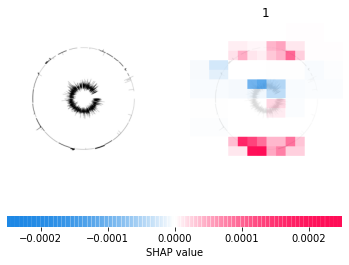

In [16]:
# python function to get model output; replace this function with your own model function.

import matplotlib.pyplot as plt
# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)
#explainer = shap.Explainer(new_model, masker, output_names=class_names)
#explainer = shap.Explainer(new_model)
i=3
# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[i:i+1], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])


#shap_values = explainer(X[0:1],  outputs=shap.Explanation.argsort.flip[:]) #max_evals=500, batch_size=4,

shap.image_plot(shap_values)#,show=False)
#plt.savefig('/research/bsi/projects/breast/s301449.LARdl/processing/MOLI/MOLI_code/Keras/xiaojia_code/Kevin_Pac/shap_sample.png')
#plt.close()   


In [298]:
#shap.image_plot(shap_values)
#shap_values[0:1].shape
#shap_values.shape

3 -6.0302738954002656e-05 8.333690296543257e-05 0.0 1.0 0.0 1.0
1 1
positive 111.29225071305392 127.01571748117618 207.97491822704333 223.01000687526167 236
negative 111.92632302358658 127.01966264874352 95.98990222636432 111.01115813997569 226


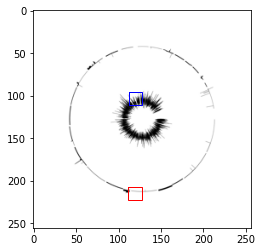

In [17]:
#for i in range(4):
#i=0
shapval = shap_values.values[0,:,:,0,0]
shap_values1=shapval.copy()
shap_values2=shapval.copy()
shap_values1[shap_values1 < 0] = 0
shap_values2[shap_values2 > 0] = 0
shap_values2=np.abs(shap_values2)
shap_values1 = (shap_values1 - shap_values1.min()) / (shap_values1.max() - shap_values1.min())
shap_values2 = (shap_values2 - shap_values2.min()) / (shap_values2.max() - shap_values2.min())
print(i,np.min(shapval),np.max(shapval),np.min(shap_values1),np.max(shap_values1),np.min(shap_values2),np.max(shap_values2))
# Set the threshold value
threshold = 0.99
#threshold = 0.00001
# Find the contours in the image
contours1 = measure.find_contours(shap_values1, threshold)
# Create a list of Polygon objects from the contours
polygons1 = [Polygon(contour) for contour in contours1]
# Create a MultiPolygon object from the list of Polygon objects
multipolygon1 = MultiPolygon(polygons1)
# Find the contours in the image
contours2 = measure.find_contours(shap_values2, threshold)
# Create a list of Polygon objects from the contours
polygons2 = [Polygon(contour) for contour in contours2]
# Create a MultiPolygon object from the list of Polygon objects
multipolygon2 = MultiPolygon(polygons2)
print(len(multipolygon1),len(multipolygon2))

mp1=[]
for p1 in multipolygon1:
    np1=np.array(p1.exterior.coords) 
    y_min=np.min(np1[:,0])
    y_max=np.max(np1[:,0])
    x_min=np.min(np1[:,1])
    x_max=np.max(np1[:,1])
    print("positive",x_min,x_max,y_min,y_max,int((x_max-x_min)*(y_max-y_min)))
    mp1.append(Polygon([[x_min,y_min],[x_min,y_max],[x_max,y_max],[x_max,y_min],[x_min,y_min]]))
mp2=[]
for p1 in multipolygon2:
    np1=np.array(p1.exterior.coords) 
    y_min=np.min(np1[:,0])
    y_max=np.max(np1[:,0])
    x_min=np.min(np1[:,1])
    x_max=np.max(np1[:,1])
    print("negative",x_min,x_max,y_min,y_max,int((x_max-x_min)*(y_max-y_min)))
    mp2.append(Polygon([[x_min,y_min],[x_min,y_max],[x_max,y_max],[x_max,y_min],[x_min,y_min]])) 
    
# Overlay the polygons on the image
fig, ax = plt.subplots()
ax.imshow(X[i])
ax.set_aspect('equal')
for polygon in mp1:
    patch = PolygonPatch(polygon, facecolor='none', edgecolor='red')
    ax.add_patch(patch)
for polygon in mp2:
    patch = PolygonPatch(polygon, facecolor='none', edgecolor='blue')
    ax.add_patch(patch)
plt.show()
#np.min(shap_values1),np.max(shap_values1)
#shap_values1 = (shap_values1 - shap_values1.min()) / (shap_values1.max() - shap_values1.min())
#
#shap_tmp = (shap_tmp - shap_tmp.min()) / (shap_tmp.max() - shap_tmp.min())
#shap_tmp.shape,shap_tmp[0,0,:],np.min(shap_tmp[:,:,0]),np.max(shap_tmp[:,:,0]),np.min(shap_tmp[:,:,1]),np.max(shap_tmp[:,:,1]),np.min(shap_tmp[:,:,2]),np.max(shap_tmp[:,:,2])

In [251]:
# !pwd
# colors = ("red", "green", "blue")
# create the histogram plot, with three lines, one for
# each color
# plt.figure()
# plt.xlim([0, 0.51])
# for channel_id, color in enumerate(colors):
#    histogram, bin_edges = np.histogram(
#         shap_tmp[:, :, channel_id], bins=256, range=(0, 1)
#     )
#     plt.plot(bin_edges[0:-1], histogram, color=color)

# plt.title("Color Histogram")
# plt.xlabel("Color value")
# plt.ylabel("Pixel count")

In [252]:
#colors = ("blue")

# create the histogram plot, with three lines, one for
# each color
#plt.figure()
#plt.xlim([0, 1])
#histogram, bin_edges = np.histogram(shap_tmp.flatten(), bins=256)#, range=(0, 1))
#plt.plot(bin_edges[0:-1], histogram, color="blue")
#plt.title("Color Histogram")
#plt.xlabel("Color value")
#plt.ylabel("Pixel count")

In [255]:
#from skimage import measure
#import numpy as np
#from shapely.geometry import MultiPolygon
#from shapely.geometry import Polygon

# Set the threshold value
#threshold = 0.9
# Find the contours in the image
#contours = measure.find_contours(shap_tmp, threshold)
# Create a list of Polygon objects from the contours
#polygons = [Polygon(contour) for contour in contours]
# Create a MultiPolygon object from the list of Polygon objects
#multipolygon = MultiPolygon(polygons)
#print(len(multipolygon))

In [233]:

#mp=[]
#p1=multipolygon[0]
#list(p1.exterior.coords)#,np.max(shap_tmp),np.min(shap_tmp)
#for p1 in multipolygon:
#    np1=np.array(p1.exterior.coords) 
#    y_min=np.min(np1[:,0])
#    y_max=np.max(np1[:,0])
#    x_min=np.min(np1[:,1])
#    x_max=np.max(np1[:,1])
#    print(x_min,x_max,y_min,y_max)
#    mp.append(Polygon([[x_min,y_min],[x_min,y_max],[x_max,y_min],[x_max,y_max],[x_min,y_min]]))

In [187]:
#X[0].shape
#p1.boundary.coords

In [300]:
#from matplotlib import pyplot as plt
#from descartes import PolygonPatch

# Load the image and convert it to RGB
#image = plt.imread(orig)
#image = image[:, :, :3]

# Overlay the polygons on the image
#fig, ax = plt.subplots()
#ax.imshow(X[1])
#ax.set_aspect('equal')
#for polygon in mp:
#    patch = PolygonPatch(polygon, facecolor='none', edgecolor='red')
#    ax.add_patch(patch)

#plt.show()

In [81]:
shap.image_plot(shap_values,show=False)
plt.savefig('shap_sample10000.png',)
plt.close()  

In [301]:
!pwd


/research/bsi/projects/pharmacogenetics/s112047.beauty/analyses/manuscripts/Naresh_ML_DP_2_2_2021/code/General-ImageClassifier_hsv_bilinear
